In [0]:
!kill -9 -1

# seq2seq

seq2seqとは。  
時系列データを別の時系列データに変化することができる手法。  
RNNを二つ組み合わせることで実現しています。 
 
 一つがEncoder、次にDecoderとして動作します。
 
 活用としては、  
 機械翻訳、自動要約、質疑応答、メールの自動返信などに利用されています。

# コーディング

## 準備

今回はせっかくなので、colabでNvidia社のTesla K80 GPUを使い、  
numpyの代わりにcupyを使って計算をさせます  

ただしそのままpipではエラーが出てしまいます。  
インストールは以下のcolabノートブックを参照   
[Brief introduction to CuPy](https://colab.research.google.com/drive/1WcNPZvgT9T3KhgMY2i8dEyUOCs-Px6Ac)  

また、Trainerクラス内でcupyに対応していない箇所があったので  
変換するよう追加しました。  

max_epochは12で回します。  

と、ワクワク回していたのですがplotのところでエラー。  
PeekySeq2seqからは  numpyで回すことにしました。  

GPUは計算自体は早かったのですが、推論がCPUの方が早かったです。  
これはコードによる関係なのかなとも思いました。

In [4]:
!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libcusparse8.0 libnvrtc8.0 libnvtoolsext1
0 upgraded, 3 newly installed, 0 to remove and 0 not upgraded.
Need to get 28.9 MB of archives.
After this operation, 71.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libcusparse8.0 amd64 8.0.61-1 [22.6 MB]
Get:2 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvrtc8.0 amd64 8.0.61-1 [6,225 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvtoolsext1 amd64 8.0.61-1 [32.2 kB]
Fetched 28.9 MB in 5s (5,719 kB/s)
Selecting previously unselected package libcusparse8.0:amd64.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../libcusparse8.0_8.0.61-1_amd64.deb ...
Unpacking libcusparse8.0:amd64 (8.0.61-1) ...
Selecting previously unselected package libnvrtc8.0:amd64.
Prepar

In [1]:
GPU = True

if GPU:
    import cupy as np
    np.cuda.set_allocator(np.cuda.MemoryPool().malloc)
    np.add.at = np.scatter_add

    print('\033[92m' + '-' * 60 + '\033[0m')
    print(' ' * 23 + '\033[92mGPU Mode (cupy)\033[0m')
    print('\033[92m' + '-' * 60 + '\033[0m\n')
else:
    import numpy as np

------------------------------------------------------------
                       GPU Mode (cupy)
------------------------------------------------------------



## function

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)


def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

## optimizer

In [0]:
class SGD:
    '''
    確率的勾配降下法（Stochastic Gradient Descent）
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]


class Momentum:
    '''
    Momentum SGD
    '''
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] = self.momentum * self.v[i] - self.lr * grads[i]
            params[i] += self.v[i]


class Nesterov:
    '''
    Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)
    '''
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] *= self.momentum
            self.v[i] -= self.lr * grads[i]
            params[i] += self.momentum * self.momentum * self.v[i]
            params[i] -= (1 + self.momentum) * self.lr * grads[i]


class AdaGrad:
    '''
    AdaGrad
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = []
            for param in params:
                self.h.append(np.zeros_like(param))

        for i in range(len(params)):
            self.h[i] += grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)


class RMSprop:
    '''
    RMSprop
    '''
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = []
            for param in params:
                self.h.append(np.zeros_like(param))

        for i in range(len(params)):
            self.h[i] *= self.decay_rate
            self.h[i] += (1 - self.decay_rate) * grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)


class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

## util

In [0]:
def to_cpu(x):
    import numpy
    if type(x) == numpy.ndarray:
        return x
    return np.asnumpy(x)


def to_gpu(x):
    import cupy
    if type(x) == cupy.ndarray:
        return x
    return cupy.asarray(x)


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


def eval_perplexity(model, corpus, batch_size=10, time_size=35):
    print('evaluating perplexity ...')
    corpus_size = len(corpus)
    total_loss, loss_cnt = 0, 0
    max_iters = (corpus_size - 1) // (batch_size * time_size)
    jump = (corpus_size - 1) // batch_size

    for iters in range(max_iters):
        xs = np.zeros((batch_size, time_size), dtype=np.int32)
        ts = np.zeros((batch_size, time_size), dtype=np.int32)
        time_offset = iters * time_size
        offsets = [time_offset + (i * jump) for i in range(batch_size)]
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                xs[i, t] = corpus[(offset + t) % corpus_size]
                ts[i, t] = corpus[(offset + t + 1) % corpus_size]

        try:
            loss = model.forward(xs, ts, train_flg=False)
        except TypeError:
            loss = model.forward(xs, ts)
        total_loss += loss

        sys.stdout.write('\r%d / %d' % (iters, max_iters))
        sys.stdout.flush()

    print('')
    ppl = np.exp(total_loss / max_iters)
    return ppl


def eval_seq2seq(model, question, correct, id_to_char,
                 verbos=False, is_reverse=False):
    correct = correct.flatten()
    # 頭の区切り文字
    start_id = correct[0]
    correct = correct[1:]
    guess = model.generate(question, start_id, len(correct))

    # 文字列へ変換
    question = ''.join([id_to_char[int(c)] for c in question.flatten()])
    correct = ''.join([id_to_char[int(c)] for c in correct])
    guess = ''.join([id_to_char[int(c)] for c in guess])

    if verbos:
        if is_reverse:
            question = question[::-1]

        colors = {'ok': '\033[92m', 'fail': '\033[91m', 'close': '\033[0m'}
        print('Q', question)
        print('T', correct)

        is_windows = os.name == 'nt'

        if correct == guess:
            mark = colors['ok'] + '☑' + colors['close']
            if is_windows:
                mark = 'O'
            print(mark + ' ' + guess)
        else:
            mark = colors['fail'] + '☒' + colors['close']
            if is_windows:
                mark = 'X'
            print(mark + ' ' + guess)
        print('---')

    return 1 if guess == correct else 0


def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s is not found' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

## layers

In [0]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力
        self.t = None  # 教師ラベル

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx


class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoidの出力
        self.t = None  # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx


class Dropout:
    '''
    http://arxiv.org/abs/1207.0580
    '''
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

## time_layers

In [0]:


class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev


class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


class LSTM:
    def __init__(self, Wx, Wh, b):
        '''
        Parameters
        ----------
        Wx: 入力`x`用の重みパラーメタ（4つ分の重みをまとめる）
        Wh: 隠れ状態`h`用の重みパラメータ（4つ分の重みをまとめる）
        b: バイアス（4つ分のバイアスをまとめる）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev


class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None


class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None


class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx


class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 教師ラベルがone-hotベクトルの場合
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # バッチ分と時系列分をまとめる（reshape）
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_labelに該当するデータは損失を0にする
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelに該当するデータは勾配を0にする

        dx = dx.reshape((N, T, V))

        return dx


class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True

    def forward(self, xs):
        if self.train_flg:
            flg = np.random.rand(*xs.shape) > self.dropout_ratio
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale

            return xs * self.mask
        else:
            return xs

    def backward(self, dout):
        return dout * self.mask


class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1,
                 Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads

    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        o2 = self.backward_lstm.forward(xs[:, ::-1])
        o2 = o2[:, ::-1]

        out = np.concatenate((o1, o2), axis=2)
        return out

    def backward(self, dhs):
        H = dhs.shape[2] // 2
        do1 = dhs[:, :, :H]
        do2 = dhs[:, :, H:]

        dxs1 = self.forward_lstm.backward(do1)
        do2 = do2[:, ::-1]
        dxs2 = self.backward_lstm.backward(do2)
        dxs2 = dxs2[:, ::-1]
        dxs = dxs1 + dxs2
        return dxs

## BaseModel

In [0]:
import pickle

class BaseModel:
    def __init__(self):
        self.params, self.grads = None, None

    def forward(self, *args):
        raise NotImplementedError

    def backward(self, *args):
        raise NotImplementedError

    def save_params(self, file_name=None): # not use here notebook
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        params = [p.astype(np.float16) for p in self.params]
        if GPU:
            params = [to_cpu(p) for p in params]

        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        if '/' in file_name:
            file_name = file_name.replace('/', os.sep)

        if not os.path.exists(file_name):
            raise IOError('No file: ' + file_name)

        with open(file_name, 'rb') as f:
            params = pickle.load(f)

        params = [p.astype('f') for p in params]
        if GPU:
            params = [to_gpu(p) for p in params]

        for i, param in enumerate(self.params):
            param[...] = params[i]

## seq2seq

In [0]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled


class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

## dataset

In [0]:
import numpy


id_to_char = {}
char_to_id = {}


def _update_vocab(txt):
    chars = list(txt)

    for i, char in enumerate(chars):
        if char not in char_to_id:
            tmp_id = len(char_to_id)
            char_to_id[char] = tmp_id
            id_to_char[tmp_id] = char


def load_data(file_name='addition.txt', seed=1984):
    file_path = os.path.dirname(os.path.abspath('~/')) + '/' + file_name

    if not os.path.exists(file_path):
        print('No file: %s' % file_name)
        return None

    questions, answers = [], []

    for line in open(file_path, 'r'):
        idx = line.find('_')
        questions.append(line[:idx])
        answers.append(line[idx:-1])

    # create vocab dict
    for i in range(len(questions)):
        q, a = questions[i], answers[i]
        _update_vocab(q)
        _update_vocab(a)

    # create numpy array
    x = numpy.zeros((len(questions), len(questions[0])), dtype=numpy.int)
    t = numpy.zeros((len(questions), len(answers[0])), dtype=numpy.int)

    for i, sentence in enumerate(questions):
        x[i] = [char_to_id[c] for c in list(sentence)]
    for i, sentence in enumerate(answers):
        t[i] = [char_to_id[c] for c in list(sentence)]

    # shuffle
    indices = numpy.arange(len(x))
    if seed is not None:
        numpy.random.seed(seed)
    numpy.random.shuffle(indices)
    x = x[indices]
    t = t[indices]

    # 10% for validation set
    split_at = len(x) - len(x) // 10
    (x_train, x_test) = x[:split_at], x[split_at:]
    (t_train, t_test) = t[:split_at], t[split_at:]

    return (x_train, t_train), (x_test, t_test)


def get_vocab():
    return char_to_id, id_to_char

## Trainer

In [0]:
# coding: utf-8
import numpy
import time
import matplotlib.pyplot as plt


class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # シャッフル
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                #################### add here
                if GPU:
                    batch_x = to_gpu(batch_x)
                    batch_t = to_gpu(batch_t)
                ####################

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()


class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # バッチの各サンプルの読み込み開始位置

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # パープレキシティの評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | perplexity %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('perplexity')
        plt.show()


def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

# train_seq2seq

addition.txtは、colabノート左上の矢印を開き、  
『ファイル』からアップロードさせることで、  
カレントディレクトリにaddition.txtをアップさせることが出来ます。  

これで準備が出来ましたので、PeekySeq2seqではなく、  
普通ものを学習させてみたいと思います

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 1[s] | loss 2.52
| epoch 1 |  iter 41 / 351 | time 2[s] | loss 2.16
| epoch 1 |  iter 61 / 351 | time 3[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 4[s] | loss 1.90
| epoch 1 |  iter 101 / 351 | time 5[s] | loss 1.85
| epoch 1 |  iter 121 / 351 | time 6[s] | loss 1.83
| epoch 1 |  iter 141 / 351 | time 7[s] | loss 1.80
| epoch 1 |  iter 161 / 351 | time 8[s] | loss 1.78
| epoch 1 |  iter 181 / 351 | time 9[s] | loss 1.77
| epoch 1 |  iter 201 / 351 | time 10[s] | loss 1.76
| epoch 1 |  iter 221 / 351 | time 12[s] | loss 1.75
| epoch 1 |  iter 241 / 351 | time 13[s] | loss 1.75
| epoch 1 |  iter 261 / 351 | time 14[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 15[s] | loss 1.75
| epoch 1 |  iter 301 / 351 | time 16[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 17[s] | loss 1.74
| epoch 1 |  iter 341 / 351 | time 18[s] | loss 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+

ValueError: ignored

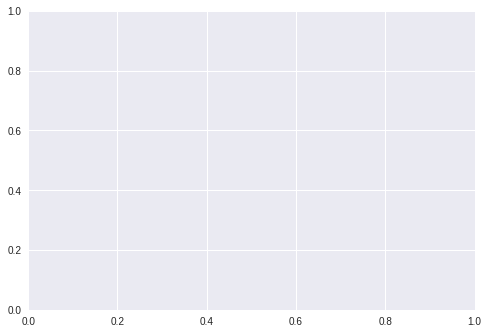

In [22]:
import sys
sys.path.append('..')
import os

# データセットの読み込み
(x_train, t_train), (x_test, t_test) = load_data('addition.txt')
char_to_id, id_to_char = get_vocab()

# Reverse input? =================================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 12
max_grad = 5.0

# Normal or Peeky? ==============================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()


## PeekySeq2seq

In [0]:
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

In [0]:
import numpy as np
GPU = False

In [0]:
# データセットの読み込み
(x_train, t_train), (x_test, t_test) = load_data('addition.txt')
char_to_id, id_to_char = get_vocab()

# Reverse input? =================================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# Normal or Peeky? ==============================================
# model = Seq2seq(vocab_size, wordvec_size, hideen_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()


noteの容量削減のため、ここでは最終的なplotのみ表示します

![代替テキスト](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAfIAAAFcCAYAAAAzhzxOAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4yLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvNQv5yAAAIABJREFUeJzt3Xl8U3W+P/5X2nRPt7RJaSldWLux%0AWBGsZbcgmxsjAoqoOMrcq/NznPHenzJzh3FhURh0XOZe9Mpch7VXrV6cyuK+QCnK2oWlFLqXNklL%0A2ibdkpzvH0gG2hTSkpPkJK/n48GDnnPSk3c/nAevnk8+5/ORCYIggIiIiCTJx9UFEBER0cAxyImI%0AiCSMQU5ERCRhDHIiIiIJY5ATERFJGIOciIhIwkQN8jNnziAnJwdbt27tdezAgQO47777sGjRIrz9%0A9ttilkFEROSxRAtyo9GIl156CVlZWTaPv/zyy3jzzTexY8cO7N+/H2fPnhWrFCIiIo8lWpD7+/vj%0A3XffhVqt7nWsuroa4eHhiI2NhY+PD6ZOnYqCggKxSiEiIvJYogW5XC5HYGCgzWMajQZKpdK6rVQq%0AodFoxCqFiIjIY0lmsJvJZHZ1CURERG5H7oo3VavV0Gq11u2GhgabXfBXam42OrQGlSoUGk2rQ8/p%0A7dimjsc2dSy2p+OxTR2rZ3uqVKHX/R6X3JHHx8ejra0NNTU1MJlM+Prrr5Gdne2KUoiIiCRNtDvy%0A4uJivPLKK6itrYVcLsfevXsxY8YMxMfHY+bMmfjTn/6E3/3udwCAuXPnIjk5WaxSiIiIPJZMKsuY%0AOrrrht1Bjsc2dTy2qWOxPR2PbepYkulaJyIiIsdgkBMREUkYg5yIiEjCGOREREQSxiAnIiKSMAY5%0AERGRhDHIiYiIJIxBTkREJGEMciIiIgljkBMREUkYg5yIiEjCGOREREQSxiAnIiKSMAY5ERGRhDHI%0AiYiIJIxBTkREJGEMciIiIgljkBMREUkYg5yIiEjCGOREREQSxiAnIiKSMAY5ERGRhDHIiYiIJIxB%0ATkREJGEMciIiIgljkBMREUkYg5yIiEjCGOREREQSxiAnIiKSMAY5ERGRhDHIiYiIJIxBTkREJGEM%0AciIiIgljkBMREUkYg5yIiEjCGOREREQSxiAnIiKSMAY5ERGRhDHIiYiIJIxBTkREJGEMciIiIglj%0AkBMREUkYg5yIiEjCGOREREQSxiAnIiKSMAY5ERGRhDHIiYiIJEzu6gKIiIikrLC0AfkFFajTGhEX%0AHYx5WUmYmBbjtPdnkBMREQ1QYWkDNu0qsW7XaAzWbWeFObvWiYiIBii/oKKP/ZVOq4FBTkRENEB1%0AWoPN/fU62/vFIGrX+po1a3D8+HHIZDKsXLkSY8aMsR7btm0bdu3aBR8fH2RkZOD3v/+9mKUQERE5%0AVHunCX5yX3R2m3sdi40KcVodogX5oUOHUFlZidzcXJSXl2PlypXIzc0FALS1teG9997Dvn37IJfL%0AsXz5chw7dgzjxo0TqxwiIiKHaTF04bUPjtsMcQCYl5XotFpEC/KCggLk5OQAAIYNGwa9Xo+2tjYo%0AFAr4+fnBz88PRqMRwcHBaG9vR3h4uFilEBEROUzjxXZszD2GxuZ2TB4Ti5TECOw+WI16nQGxUSGY%0Al5XoGaPWtVot0tPTrdtKpRIajQYKhQIBAQF48sknkZOTg4CAAMybNw/JyclilUJEROQQVQ2t2Pi/%0Ax9Fi6ML82xJx7+ShkMlkyEqPdVlNTnv8TBAE69dtbW3YtGkT9uzZA4VCgYcffhinTp1CSkpKn98f%0AGRkMudzXoTWpVKEOPR+xTcXANnUstqfjeUubnjirwSvbj6Kjy4Qn7hmNOycPFeV9+tueogW5Wq2G%0AVqu1bjc2NkKlUgEAysvLMWTIECiVSgDA+PHjUVxcfM0gb242OrQ+lSoUGk2rQ8/p7dimjsc2dSy2%0Ap+N5S5v+dKoR73xaAkEAVtyVjgkpKlF+7p7taU+oi/b4WXZ2Nvbu3QsAKCkpgVqthkKhAAAMHjwY%0A5eXl6OjoAAAUFxcjKSlJrFKIiIgG7KsjNfjPT4oh9/XBM/ePxYRU533+bQ/R7sgzMzORnp6OxYsX%0AQyaTYdWqVcjLy0NoaChmzpyJxx57DMuWLYOvry9uuukmjB8/XqxSiIiI+k0QBHzy/Xl8eqACYcF+%0AeOb+cUgc5H4fI8iEKz+8dmOO7sLwlu4gZ2KbOh7b1LHYno7nqW1qtliwZe8ZfHe8DqqIQPxu0Tio%0AI4NFf9+BdK1zrnUiIqIrdHWbsWlXCY6WaZEQo8Az949DeIi/q8vqE4OciIjoZ8aObrzx4QmcqdEj%0ANTESTy0YjaAA945K966OiIhIRFcuQRqjDEJHlxnNrZ24JUWNX85Pg5/c/ZckYZATEZFX6rkEab3u%0A0mPO6UlKrLg7HT4ymatK6xf3/1WDiIhIBH0tQao3dEomxAEGOREReak6re2Jxi7fmUsFg5yIiLyS%0AKiLQ5n5nLkHqCAxyIiLyOrVaA/SGLpvHnLkEqSNwsBsREXmVep0B63ccRUeXGZPHxuJ8XavLliB1%0ABAY5ERF5jYZmI9bvOIoWQxcenDkSt98c7+qSbhi71omIyCtoLrbj1e1HcbGtC4tnDPeIEAcY5ERE%0A5AW0+ksh3tzaiYXThmHWhARXl+QwDHIiIvJoTS0dWL/jKHQtHbh3ylDMuVVag9muh0FOREQeq7m1%0AE+t3HIXmYgfuyk7Cnbclubokh2OQExGRR9IburBh51E0NLdjXlYi7p6U7OqSRMEgJyIij9Ni7MKG%0AHUdRrzPijglDsGDKUMgkNO1qfzDIiYjIo7S1d2PDjmOo1RqQc3M87p8+3GNDHGCQExGRBzF0dOPP%0AO4+hRtOG6TcNxpKcER4d4gCDnIiIPISxw4SNucdQ2dCKKWNj8eCskR4f4gBndiMiIokqLG1AfkEF%0A6rRGDIoKhslsQWNzO7JHD8Ky2SmSWor0RjDIiYhIcgpLG7BpV4l1u05rAAAMjw/Ho3NSvSbEAXat%0AExGRBOUXVNjc39Fpgo+P94Q4wCAnIiIJqtMabe6v19ne78kY5EREJDlx0cE298dGhTi5EtdjkBMR%0AkeT0tejJvCzPmkfdHhzsRkREklPT2AYAUAT5ob3ThNioEMzLSsTEtBgXV+Z8DHIiIpKU8lo9Pv+x%0AGurIILywfAIC/HxdXZJLsWudiIgko9tkxubPTgIAls9N9foQBxjkREQkIf/3QwXqdUbMuDkeI4dE%0AuLoct8AgJyIiSThf34I9hVWIDg/EfVOHuboct8EgJyIit2cyW7D5s5OwCAIenZOCAH92qV/GICci%0AIrf3jwMVqNUYMG1cHFKTlK4ux60wyImIyK1VNbQiv6ASyrAALJw+3NXluB0GORERuS2T2YLN+Sdh%0Atgh4ZHYKggL41HRPDHIiInJbuwurUNXYhkmjY5ExNMrV5bglBjkREbmlWk0bPt1/HhEKfyy+nV3q%0AfWGQExGR2zFbLo1SN5kFLJudguBAP1eX5LYY5ERE5Hb2HarG+fpWZKXHYNzwaFeX49YY5ERE5Fbq%0AdQZ8/P15hIX4Y0nOSFeX4/YY5ERE5DYsFuHnLnULHpo1EoogdqlfD4OciIjcxheHa1Be24JbUtS4%0AeZTa1eVIAoOciIjcQkOzEXnflkMR5IcHZ7FL3V4MciIicjmLIOBvn51Cl8mCpbNGIizY39UlSQaD%0AnIiIXO6bo7U4U30RN42Ixi0p7FLvDwY5ERG5lPZiOz74uhwhgXIsu2MUZDKZq0uSFE5aS0RELlFY%0A2oD8ggrUaAwAgNsy4hCuCHBtURLEO3IiInK6wtIGbNpVYg1xAPj6aB0KSxtcWJU0MciJiMjp8gsq%0A+thf6dQ6PAGDnIiInK5Oa7C5v15nez/1jUFOREROJQgCAv1tD9GKjQpxcjXSxyAnIiKn+upILYyd%0AJpvH5mUlOrka6RN11PqaNWtw/PhxyGQyrFy5EmPGjLEeq6+vx29/+1t0d3cjLS0NL774opilEBGR%0AGzhTfRE7vyxDaLAf7spOxrfH6lCvMyA2KgTzshIxMS3G1SVKjmhBfujQIVRWViI3Nxfl5eVYuXIl%0AcnNzrcfXrVuH5cuXY+bMmXjhhRdQV1eHuLg4scohIiIXa27txF8/KYYgAP96TwZGJUTi9pvjXV2W%0A5InWtV5QUICcnBwAwLBhw6DX69HW1gYAsFgsOHz4MGbMmAEAWLVqFUOciMiDdZss+OvHRWgxdGHR%0AjOEYlRDp6pI8hmh35FqtFunp6dZtpVIJjUYDhUKBpqYmhISEYO3atSgpKcH48ePxu9/97prni4wM%0Ahlzu69AaVapQh56P2KZiYJs6FtvT8exp07c+OIbyuhZMy4zHkjmpnL3tGvp7jTptZjdBEK76uqGh%0AAcuWLcPgwYPxxBNP4JtvvsG0adP6/P7mZqND61GpQqHRtDr0nN6Obep4bFPHYns6nj1t+t3xOuw9%0AWIkEtQKLpg+DVtvmpOqkp2d72hPqonWtq9VqaLVa63ZjYyNUKhUAIDIyEnFxcUhISICvry+ysrJQ%0AVlYmVilEROQi5XV6bN13GiGBcjy1YDQC/Bzbs0oiBnl2djb27t0LACgpKYFarYZCoQAAyOVyDBky%0ABBUVFdbjycnJYpVCREQuoDd04a8fF8NsEfCruzMQHRHk6pI8kmhd65mZmUhPT8fixYshk8mwatUq%0A5OXlITQ0FDNnzsTKlSvx3HPPQRAEjBw50jrwjYiIpM9ktuA/Py5Cc2sn7ps2DOnJSleX5LFE/Yz8%0A2WefvWo7JSXF+nViYiJ27Ngh5tsTEZGL/O9XZ3GmRo/xo1SYMzHB1eV4NM7sRkREDnWguB5fHK7B%0A4OgQLJ/HEepiY5ATEZHDVF5oxft7TiMo4NLgtr7mVCfHYZATEZFDtBq78FZeEUwmC564Mw0xymBX%0Al+QVGORERHTDzBYL/uv/SqBr6cDdk5Ixdni0q0vyGnYF+ZWTuRAREfX00bfncLKyGeOGR2N+dpKr%0Ay/EqdgX59OnT8dprr6G6ulrseoiISGIOnWzAnsIqxCiD8cv5afDh4DansmsUwgcffIC9e/di5cqV%0AkMvlWLBgAe644w74+/uLXR8REbmhwtIG5BdUoE5rhCAIkPvK8OsFoxEcyMFtzmbXHblKpcLSpUux%0AZcsW/OlPf8KOHTswefJkvPbaa+js7BS7RiIiciOFpQ3YtKsENRoDLIIAAYDJLKC6kXOou4Ldg91+%0A/PFHPP/883j88ceRmZmJ7du3IywsDE8//bSY9RERkZvJL6joY3+lU+ugS+zqA5k5cyYGDx6M+++/%0AHy+++CL8/PwAXFpn/IsvvhC1QCIici91WturUdbrDE6uhAA7g/y///u/IQgCkpKSAAClpaVIS0sD%0AAGzfvl204oiIyP1ERwSisbm91/7YqBAXVEN2da3n5eVh06ZN1u133nkHGzZsAABOvUdE5EU6ukzo%0A6DLZPDYvK9HJ1RBg5x15YWEhdu7cad1+/fXXsWTJEtGKIiIi97T98zK0GLoxdngUdPpO1OsMiI0K%0AwbysRExMi3F1eV7JriDv7u5GV1eX9XEzg8EAk8n2b2REROSZDp1swA9F9UiMCcWT946G3NcHKlUo%0ANJpWV5fm1ewK8sWLF2Pu3LnIyMiAxWJBUVERnnrqKbFrIyIiN6HVt+P9Pafh7+eDFXenQ+7LGb7d%0AhV1BvnDhQmRnZ6OoqAgymQzPP/88FAqF2LUREZEbsFgEvPtpKdo7TXhkTgoGcTEUt2L3r1RGoxFK%0ApRKRkZE4d+4c7r//fjHrIiIiN/GPggqU1egxfpQKk8fEuroc6sGuO/KXX34Z+/fvh1arRUJCAqqr%0Aq7F8+XKxayMiIhc7W6vHrh8qoAwLwMNzUvikkhuy6468qKgIu3fvRkpKCj766CNs3rwZ7e29nyEk%0AIiLPYeww4Z1dJRAEAY/PT0NIoJ+rSyIb7Aryy6PVu7u7IQgCMjIycOTIEVELIyIi19r6+Wlo9R2Y%0Ad1siRiVEuroc6oNdXevJycnYtm0bxo8fj0cffRTJyclobeXjBkREnqqg+AIOljRgaFwY7spOdnU5%0AdA12BfkLL7wAvV6PsLAw5OfnQ6fTYcWKFWLXRkRELtB4sR1b9p1GoL8vnriLj5q5O7uCfM2aNfj9%0A738PALjzzjtFLYiIiFzHZLbgnV0l6Ogy4/H5aVBHBLm6JLoOu37N8vX1RUFBATo7O2GxWKx/iIjI%0As+zaX4FzdS24NS0GWRmDXF0O2cGuO/IPPvgA77//PgRBsO6TyWQ4efKkaIUREZFzna5qRv6BCkSH%0AB2LprFGuLofsZFeQHz58WOw6iIjIhQwd3Xj3H6WQyWR44q50BAfaFQ/kBuz6l/rLX/5ic//TTz/t%0A0GKIiMj5BEHA+7tPoamlE/dMTsbwweGuLon6we7PyC//sVgsKCws5ONnREQe4ocT9fjptAYj4sMx%0APyvJ1eVQP9l1R95zpTOz2Yxf//rXohRERETOc6HJiO1flCEoQI7H70yDjw+nYJWaAT0caDKZUFVV%0A5ehaiIjIiUxmCzbtKkFntxkPzx6F6HA+aiZFdt2RT5069aqJ8vV6Pe69917RiiIiIvEUljYgv6AC%0AtRoDBACjhkRgQmqMq8uiAbIryLdv3279WiaTQaFQICwsTLSiiIhIHIWlDdi0q+SqfaerL6KwtAET%0A0xjmUmRX13p7ezt27tyJwYMHIy4uDmvXrkVZWZnYtRERkYPlF1T0sb/SqXWQ49gV5C+88AKmTp1q%0A3f7FL36BF198UbSiiIhIHLVag8399Trb+8n92RXkZrMZ48ePt26PHz/+qlneiIjI/Z2pvtjnsdio%0AECdWQo5k12fkoaGh2L59OyZOnAiLxYLvv/8eISH8RycikopjZ7X4z0+K+zw+LyvRidWQI9kV5GvX%0ArsWf//xn7NixAwCQmZmJtWvXiloYERE5xoHiemzOPwW5rwy/WTgWxg4T8gsqUa8zIDYqBPOyEjnQ%0ATcLsCnKlUonHH38cSUlJAIDS0lIolUox6yIiIgf4/Mdq7PiyDMEBcvxm4VgMj780/SqD23PY9Rn5%0Aa6+9hk2bNlm333nnHWzYsEG0ooiI6MYIgoCPvzuHHV+WIVzhj+cezLSGOHkWu+7ICwsLsXPnTuv2%0A66+/jiVLlohWFBERDZzFImDb52fw9dFaqCOC8NvF46CO4KxtnsquIO/u7kZXVxf8/f0BAAaDASaT%0ASdTCiIio/0xmC/77H6U4dLIRQ9QK/Pb+sQhXBLi6LBKRXUG+ePFizJ07FxkZGbBYLCgqKsLDDz8s%0Adm1ERNQPnV1mvP1xEYrPN2FEfDievm8MggP9XF0WicyuIF+4cCGSkpLQ3NwMmUyGGTNmYNOmTXjk%0AkUdELo+IiOzR1t6Nv3xwHOV1LRgzLAr/ck8GAvx8XV0WOYFdQb569Wr88MMP0Gq1SEhIQHV1NZYv%0AXy52bUREZIfm1k5s/N9jqNUYkJUeg0fnpkLuO6DFLUmC7PqXPnHiBHbv3o2UlBR89NFH2Lx5M9rb%0A28WujYiIrqOh2Yi1Ww+jVmNAzs3xeGx+GkPcy9j1r315kFt3dzcEQUBGRgaOHDkiamFERHRtVQ2t%0AWLvlMLT6DtwzORlLckbA54olp8k72NW1npycjG3btmH8+PF49NFHkZycjNbWVrFrIyKiHqxrif+8%0A+IkgAEtnjcSMzHjXFkYuY1eQv/DCC9Dr9QgLC0N+fj50Oh1WrFghdm1ERHQFW2uJA0AIR6Z7NbuC%0AXCaTISIiAgBw5513iloQERHZ9umBCpv78wsqOeWqF+OICCIiCTh2Vos6riVONth1R05ERK7RYujC%0A9i/O4NDJxj5fw7XEvZuod+Rr1qzBokWLsHjxYpw4ccLma/785z/joYceErMMIiLJEQQB+4vq8ft3%0AD+LQyUYMiwvDwmnDbL6Wa4l7N9HuyA8dOoTKykrk5uaivLwcK1euRG5u7lWvOXv2LH788Uf4+XGg%0ABhHRZdqL7fj73tMoPt+EAD9fLMkZgdsz4+HjI4MyLJBridNVRAvygoIC5OTkAACGDRsGvV6PtrY2%0AKBQK62vWrVuHZ555Bm+99ZZYZRARSYbFIuDLwzXI++4cOrvNyEhWYtnsUYgO/+fKZRPTYhjcdBXR%0Aglyr1SI9Pd26rVQqodForEGel5eHCRMmYPDgwXadLzIyGHK5Y+cNVqlCHXo+YpuKgW3qWO7anpX1%0ALXjzf4/hdFUzQoP98eTCsZiWGQ+ZBCZ4cdc2lar+tqfTBrsJgmD9+uLFi8jLy8Pf/vY3NDQ02PX9%0Azc1Gh9ajUoVCo+GkNo7ENnU8tqljuWN7dpssyC+oQH5BJcwWARPTYrDk9hEIC/GHVtvm6vKuyx3b%0AVMp6tqc9oS5akKvVami1Wut2Y2MjVCoVAODgwYNoamrCgw8+iK6uLlRVVWHNmjVYuXKlWOUQEbnc%0A5VnZ6rRGxEUH4+ZRahw62YB6nRHKsAA8NGsUxg6PdnWZJDGiBXl2djbefPNNLF68GCUlJVCr1dZu%0A9dmzZ2P27NkAgJqaGjz//PMMcSLyaD1nZavRGFCjOQ8AmJE5GL+YOgxBAXwimPpPtKsmMzMT6enp%0AWLx4MWQyGVatWoW8vDyEhoZi5syZYr0tEZFbyi+osLlfHRGEpbNGObUW8iyi/vr37LPPXrWdkpLS%0A6zXx8fHYsmWLmGUQEblEZ7cZZTUXcbKiGTUa27Ov6Vo6nFwVeRr24xAROYjJbEFFfStKK5twsqIZ%0A5XV6mMzCNb+Hs7LRjWKQExHZoedAtXlZSbglVY2axjacrGzGycpmnK6+iM4uMwBABiAhJhSpSZFI%0AS4zExbYubP7sZK/zclY2ulEMciKi67A1UG3TrhK8v+cUOn4ObgCIUQYjLTESqYmRSEmMhCLo6lkr%0A/eQ+nJWNHI5BTkR0HX0NVOsyWZCVPghpSZfCWxkWeM3zcFY2EgODnIjoOvpaPlQG4PE705xbDFEP%0AXI+ciOgajB0myH1t/1fJgWrkDnhHTkTUB2NHN/6cewxdJovN4xyoRu6AQU5EZENb+6UQr7zQiuzR%0Ag5CepMRnB6s4UI3cDoOciKiHtvZubNhxFFWNbZgyNhbLZqfARybDremDXF0aUS8MciKiK7QYu7Bh%0AxzHUaNowbVwclt4xCj4SWEqUvBeDnIjoZy2GLqzfeRS1GgOmZw7GgzNHMsTJ7THIiYgA6A1dWL/j%0AKOq0Btx+czweyBkBGUOcJIBBTkRe72JbJ9bvOIp6nREzxw/B4tuHM8RJMhjkROTVmls78eqOo2ho%0AMmL2hAQsnD6MIU6SwiAnIq/V1NKBV3ccRWNzO+bcmoD7pjLESXoY5ETklXT6Dry64wg0Fzsw/7ZE%0A3Dt5KEOcJIlBTkReR6tvx6vbj0Kr78Bd2Um4e1IyQ5wki0FORF5Fc/FSiOtaOnDPpGTcNSnZ1SUR%0A3RAGORF5vMLSBuQXVKBOa4RMBpgtAu6dMhR33pbk6tKIbhiDnIg8WmFpAzbtKvnnDuHSX+qIINcU%0ARORgXMaUiDxafkFFH/srnVoHkVgY5ETksdrau1GjMdg8Vq+zvZ9Iati1TkQeqfi8DpvzT/Z5PDYq%0AxInVEImHQU5EHqWz24wPvy7Hl0dq4Osjw4RUNQ6dbOz1unlZiS6ojsjxGORE5DEqLrTg3U9LUa8z%0AIjYqGE/cmY7EQaG4aUQD8gsqUa8zIDYqBPOyEjExLcbV5RI5BIOciCTPbLHgs4NV2PXDeZgtAnLG%0Ax+O+qcPg7+cLAJiYFoOJaTFQqUKh0bS6uFoix2KQE5GkNTYb8e4/SlFe24LI0AAsn5eK9CSlq8si%0AchoGORFJkiAI+P5EPXZ8UYbObjMmpKqxdNYoKIL8XF0akVMxyIlIcloMXfif3adw7KwWQQFyPHFX%0AGm5NG+TqsohcgkFORG7tyulV46KDkZ6sxIHiC2g1diM1MRKPzUuFMizQ1WUSuQyDnIjcVs/pVWs0%0ABtRoDPCRybD49hHIGR8PH65aRl6OQU5Ebquv6VVVkYGYdcsQp9ZC5K44RSsRua06re1pVLUXO5xc%0ACZH74h05EdnU87PpeVlJTp1Epfi8DjKZDBCEXsc4vSrRPzHIiagXW59NX94WO8wNHd3Y+WUZ9hdd%0AQF+ffnN6VaJ/YpATUS99L/1ZIWqQHz7diK37zkBv6EJCjALL56aiXmfk9KpE18AgJ6Je+vpsukZj%0AwN5DVZgyNg5BAY7770Pf1oltn5/BT6c1kPv64BdTh+KOCQmQ+/ogISaUwU10DQxyIrpKjaatz8+m%0AZQByvzqLXfsrMG1cHHLGD0FkaMCA30sQBBwovoCdX5bB0GHC8PhwPDonhZ+BE/UDg5yIrEormvD2%0Ax0UwW3qHOAAsmz0KrcZufHG4BrsLq7Dvx2rcmh6D2RMSMFil6Nd76fQdeH/vKRSfa0KAny8enDkS%0A0zMH87lwon5ikBMRAGB/UT3+Z/cpyGTAirvSAaDPz6bvmDAEBSUN2FNYhf1FF7C/6AJGD43C7IkJ%0ASEmIuHRH3weLIOCbo7X44JtydHaZkZ6sxMOzRyE6PMgpPyeRp2GQE3k5QRDw6f4KfPLDeYQEyvHU%0AgtEYlRAJoO8R6n5yX0wZG4dJY2Jx4qwOeworUXROh6JzOiQOCsXsCQkYn6LCT6c0Vz3Clj06FkfP%0AaHCmRo/gADmWz01F9uhB1wx+Iro2mSDY+CDMDTl6DWGuS+x4bFPHE7tNTWYL/r7nNH4oqkd0eCCe%0AuX/sgD+fLq/TY09hFY6c1kAAEBrkh9b2bpuvvXmkCktnjUS4YuCfrw8Er1HHY5s6Vs/2VKlCr/s9%0AvCMn8lLtnSb89eMilFQ0I2lQKJ5eOBbhIf4DPt+wuHA8ee9oNDQbse9QNb4+WmvzdVFhgXhywegB%0Avw8RXY1TtBJ5oaaWDqzdegQlFc0YNzwa//8DmTcU4leKiQzGQ3eMgk8fveUX2zod8j5EdAnvyIm8%0ATFVDK/7y4Qk0t3ZieuZgPJgzEj59pe4NiIsOQY2m9/PofLSMyLF4R07kRYrP67Bu2xE0t3bi/unD%0AsXSmOCEOAPOykvrYz+lViRyJd+REXuL7E3X4+57TkMlk+Jd7MnBLilrU97s84p3TqxKJi0FO5IF6%0ArlwWExmEw2e0CAmU4/+7bwyi/K0XAAAT7klEQVRGxEc4pY6JaTEMbiKRMciJPIytlctqNAaEBvvh%0A+aU3Y5Ay2IXVEZGj8TNyIg/T18ploUF+DHEiDyTqHfmaNWtw/PhxyGQyrFy5EmPGjLEeO3jwIDZu%0A3AgfHx8kJydj9erV8PHh7xVEN6pOa7S5v6G53cmVEJEziJachw4dQmVlJXJzc7F69WqsXr36quN/%0A/OMf8cYbb2Dnzp0wGAz4/vvvxSqFyKuEK2w/D87Hvog8k2h35AUFBcjJyQEADBs2DHq9Hm1tbVAo%0ALq2QlJeXZ/1aqVSiublZrFKIvEK3yYIdX5ahudX2hCt87IvIM4l2R67VahEZGWndViqV0Gg01u3L%0AId7Y2Ij9+/dj6tSpYpVC5PF0+g6s23YE3xytxRC1AktuH454lQK+PjLEqxRYcVc6R48TeSinjVq3%0AtTaLTqfDr371K6xateqq0LclMjIYcrmvQ2uyZzJ66h+2KfDd0Rp88GUZqhpakRATioW3j8CUm+IH%0AfL7rtemxM414dcthtBq7MGP8EPzLL8Yg0F+OB+amD/g9PRmvUcdjmzpWf9tTtCBXq9XQarXW7cbG%0ARqhUKut2W1sbHn/8cfzmN7/BpEmTrnu+5mbbA3gGiiv2OB7btPejXxX1LVi/9TBaWjoGdEd8rTa1%0ACALyCyrxyXfn4Osrw7I7RmHquDi06tvh3f8KfeM16nhsU8cayOpnonWtZ2dnY+/evQCAkpISqNVq%0Aa3c6AKxbtw4PP/wwpkyZIlYJRE7X16Nf+QWVDn0fY0c33vqoCB9/dw6RYQF47sGbMe2mwVzXm8gL%0AiXZHnpmZifT0dCxevBgymQyrVq1CXl4eQkNDMWnSJHzyySeorKzEhx9+CACYP38+Fi1aJFY5RKJr%0A7zShVtt7kRAAqNPZ3j8QVQ2tePvjImgudiAtKRIr7kpHaLBjVi4jIukR9TPyZ5999qrtlJQU69fF%0AxcVivjWR07S1d+PLwzX44qdq2BgKAgCwWARszD2GrPRByBypQoD/wMZ77C+qx9/3nka3yYL5tyXi%0AnklDRVv0hIikgVO0Eg2Q3tCFfYeq8NXRWnR2mRESKMf4USr8dFrT67XqyCAUn29C8fkmBPj5InNk%0ANLLSByE1KRK+dkyEdPnRsm+O1iIoQI5/uTsD40ZEi/FjEZHEMMiJ+kmn78Cewip8d6IO3SYLwkP8%0AcXd2MqbdFIdAf/nPC5b0XvGrocmIgpILP/9pQEFJA8JD/DExLQZZ6YOQEKOw+Rm3Tt+Bv35SjPP1%0ALYhXKfDkggzERHKqVSK6RCbYei7MDTl6VCRHWjqep7dpQ7MRnxVU4kDxBZgtAqLCAjH31gRMGhML%0Av348GikIAsrrWlBQfAGHTjbA0GECAMRFhyArPQa3pg3C2Vr9z6uXXfps3SIAt2UMwkN3jEKAn2Mf%0Aw/Qmnn6NugLb1LEGMmqdd+RE11GjaUN+QSUOnWyAIACDlMHWu2y5b/8f/JDJZBg+OBzDB4djSc4I%0AFJ3ToaD4Ao6d1eGjb8/ho2/P2fy+jGQlQ5yIemGQE13hynW8oyMCERwgR8WFS78dD1ErMC8rEeNH%0AqR02wEzu64ObRqhw0wgVjB3d+Om0Btu/OIOubkuv1352sAq3pg9yyPsSkedgkBP9rOdkLo0/rxam%0AjgzC4ttHYOywKFGf0w4O9MOUsXH4+57TNo/XO/ARNiLyHFw3lOhnn+4/b3O/v9wH44ZHO22ylbho%0A2wPZuHoZEdnCICevJwgCCksbUKezPQ1wfR/7xTIvK6mP/Vy9jIh6Y9c6ebWmlg5s2Xsax8t1fb7G%0A2XfCl+dkt/UIGxFRTwxy8koWQcC3R2vxwTfl6OgyIyUhAuNGRGPnl2d7vdYVd8IT02IwMS2Gj/YQ%0A0XUxyMnr1OsM+J/dp1BWo0dQgByPzEnB5DGxkMlkCA8J4J0wEUkKg5y8hslswe7CKny6/zxMZgE3%0Aj1ThwVkjEaEIsL7m8p0wEZFUMMjJK5yvb8HfPjuJGo0B4SH+WDprJG4epXZ1WUREN4xBTh6ts8uM%0Aj78/h89/XplsythY3D99OIID/VxdGhGRQzDIyWNcOStbXHQwxg6PRmFpA7T6DqgjgvDwnBSkJka6%0AukwiIodikJNH6DkrW43GgBqNATIAcyYm4O5JyfDnPOVE5IEY5OQR8gsqbO5XRwZh4fThTq2FiMiZ%0AOLMbeYRare15yLX6DidXQkTkXLwjJ0lrMXbhk+/OQRBsH+f85ETk6RjkJEkmswVfHa7B/+2vQHun%0ACREKf1xs6+r1Os5PTkSejkFOknOiXIsdX55FQ5MRwQFyPJAzAtNuGozDpzWclY2IvA6DnCSjXmfA%0Azi/PouicDjIZMCNzMO6ZPBSKoEvPhHNWNiLyRgxycnuGjm7s+qECXx2pgdkiIDUxEktuH4F4tcLV%0ApRERuRyDnNyWxSLg2+N1+Pi7c2hr74YqIhCLZ4zAuBHRkMlkri6PiMgtMMjJLfSclW3cCBWOlWlR%0Ao2lDgL8vFk4bhpzxQ+An5xOTRERXYpCTy/U1KxsATBodi19MHYrwK1YoIyKif2KQk0u1GLuQ9225%0AzWPqyCAsn5fq5IqIiKSFQU43zNotrjMiLioY87KSrho9LggCWo3dqNUaUHfFn1qtAW3t3X2eV8dZ%0A2YiIrotBTjfEVrf4pl0lKD6vg5/c1xraPQNbBkAVEYThg8NRXqdHq7F3oHNWNiKi62OQ0w3pa7GS%0A/UUXAPwc2JFBGBEfjrjokEt/okIQGxVsXY2s5y8Dl3FWNiKi62OQ04B1myyo1dherEQmA1Y9cgsG%0AKYOvu3zo5W54zspGRNR/DHIakKJzOmz//Az6WKsEg6MVSIgJtft8nJWNiGhgGOTUL5qL7dj5ZRmO%0AlmkhkwEZyUoUn2/q9Tp2ixMROQeDnOzS1W3GZwcrsbuwCt0mC0YOicCDM0diiFrx86h1dosTEbkC%0Ag5yuSRAEHC3TYueXZdDqOxCh8Mf9M4ZjYmqMdZrUy93iKlUoNJpWF1dMRORdGOTUpwtNRmz/4gyK%0AzzXB10eGORMTMP+2JAQF8LIhInIX/B+ZeunoMuEfByqx91AVzBYB6UmReGDmSD7XTUTkhhjkXq7n%0AYiUpCZE4fEaD5tZORIUFYPHtI5A5UsXVxoiI3BSD3Iv1tViJj0yGO29LwtysRARc5xlwIiJyLQa5%0AF/vHgQqb+9WRQbh3ylDnFkNERAPCIPcyZosFp6ou4seTDajV2p6VTXOx3clVERHRQDHIvYDFIqCs%0A5iIOnWzET6cbrQuU+PjIYLH0npuNg9qIiKSDQe6hLIKA8lq9Nbz1bV0AgNBgP0y/aTAmpKrR3NqJ%0Adz4t7fW9nJWNiEg6GOQS1nPE+dxbE6GODMahkw346XQjmlo6AQAhgXJMGRuHW1LVSEmIgK+Pj/Uc%0AMpmMs7IREUkYg1yibI04v/LuOihAjuzRgzAhNQapiZGQ+/rYOg0XKyEikjgGuQS1d5rw4TflNo8F%0AB8jxy/lpSE9Wwk9uO7yJiMhzMMglQBAE1GgMKDqnQ/E5Hcpq9DDbGKQGAJ3dZowbEe3kComIyFUY%0A5G7K2NGNkopma3hf/HmwGgAkDQqFrqXDOvr8ShxxTkTkXRjkLmJroNqgqGAUnWtC0TkdztW2wCJc%0AuutWBPnh1vQYjB4ahfQkJcJC/Ht9Rn4ZR5wTEXkXBrkLXG+gmkwGDIsLR8ZQJUYPjULioFD49Jjr%0A/PIANY44JyLybgxyJ2lr70ZFfQvO1bdgT2GVzdcEB8qx7I5RSEtSQhHkd91zcsQ5ERGJGuRr1qzB%0A8ePHIZPJsHLlSowZM8Z67MCBA9i4cSN8fX0xZcoUPPnkk2KWYmXt0tYZERcVjHlZSf0Ow57d4j3P%0A0dllRmVDK87Xt+B8fQsq6lvRaMe0p51dZkxIZTATEZH9RAvyQ4cOobKyErm5uSgvL8fKlSuRm5tr%0APf7yyy/jvffeQ0xMDJYuXYo77rgDw4cPF6scALa7tC9v2xvmfZ2jtKIJAHC+vhW12jYIVwwqDwmU%0AIyNZiaTYMAyNDcMH35xFvc7Y69wcqEZERP0lWpAXFBQgJycHADBs2DDo9Xq0tbVBoVCguroa4eHh%0AiI2NBQBMnToVBQUFogd5fkGFzf1b9p7G8bNa6+Ayi3DpkS+h598ATldftHmO70/UAwD85T4YPjgc%0AybFhP/8JhSoi6Kr1vDu7zRyoRkREDiFakGu1WqSnp1u3lUolNBoNFAoFNBoNlErlVceqq6vFKsWq%0ATtv7LhgAjJ0mHCxtuKFzy2TAnx6dgLjo4KumQLWFA9WIiMhRnDbYTRBsT2BiL5Uq9IZrSBgUior6%0All77k2LD8Oaz0+06x683fG3zHImDwpCZHmt3LfOnhmL+VHF7IFzBEf9OdDW2qWOxPR2PbepY/W1P%0A0YJcrVZDq9VatxsbG6FSqWwea2hogFqtFqsUK3vDWuxzEBEROYpok3FnZ2dj7969AICSkhKo1Woo%0AFAoAQHx8PNra2lBTUwOTyYSvv/4a2dnZYpVCRETksWTCjfZ5X8OGDRvw008/QSaTYdWqVSgtLUVo%0AaChmzpyJH3/8ERs2bAAAzJo1C4899phYZRAREXksUYOciIiIxMV1LomIiCSMQU5ERCRhXjnX+rWm%0AjqX+KywsxNNPP40RI0YAAEaOHIn/+I//cHFV0nTmzBn867/+Kx555BEsXboU9fX1+Pd//3eYzWao%0AVCqsX78e/v7+ri5TMnq253PPPYeSkhJEREQAAB577DFMmzbNtUVKzKuvvorDhw/DZDJhxYoVGD16%0ANK/RG9CzPb/66qt+X6NeF+TXmzqWBmbChAl44403XF2GpBmNRrz00kvIysqy7nvjjTfwwAMPYM6c%0AOdi4cSM+/PBDPPDAAy6sUjpstScA/Pa3v8X06XyMdCAOHjyIsrIy5Obmorm5Gffeey+ysrJ4jQ6Q%0Arfa89dZb+32Nel3Xel9TxxK5mr+/P959992r5lQoLCzE7bffDgCYPn06CgoKXFWe5NhqT7oxt9xy%0AC/7yl78AAMLCwtDe3s5r9AbYak+z2dzv83hdkGu1WkRGRlq3L08dSzfm7Nmz+NWvfoUlS5Zg//79%0Ari5HkuRyOQIDA6/a197ebu2mjIqK4rXaD7baEwC2bt2KZcuW4ZlnnkFTU5MLKpMuX19fBAcHAwA+%0A/PBDTJkyhdfoDbDVnr6+vv2+Rr2ua70nPn1345KSkvDUU09hzpw5qK6uxrJly7Bv3z5+TuZgvFZv%0A3N13342IiAikpqbinXfewVtvvYU//vGPri5Lcr744gt8+OGH2Lx5M2bNmmXdz2t0YK5sz+Li4n5f%0Ao153R36tqWNpYGJiYjB37lzIZDIkJCQgOjoaDQ03tggNXRIcHIyOjg4AzpvK2JNlZWUhNTUVADBj%0AxgycOXPGxRVJz/fff4//+q//wrvvvovQ0FBeozeoZ3sO5Br1uiC/1tSxNDC7du3Ce++9BwDQaDTQ%0A6XSIieFKbo5w2223Wa/Xffv2YfLkyS6uSNp+/etfW1daLCwstD5pQfZpbW3Fq6++ik2bNllHVfMa%0AHThb7TmQa9QrZ3brOXVsSkqKq0uStLa2Njz77LNoaWlBd3c3nnrqKUydOtXVZUlOcXExXnnlFdTW%0A1kIulyMmJgYbNmzAc889h87OTsTFxWHt2rXw8/NzdamSYKs9ly5dinfeeQdBQUEIDg7G2rVrERUV%0A5epSJSM3NxdvvvkmkpOTrfvWrVuHP/zhD7xGB8BWey5YsABbt27t1zXqlUFORETkKbyua52IiMiT%0AMMiJiIgkjEFOREQkYQxyIiIiCWOQExERSRiDnIgGJC8vD88++6yryyDyegxyIiIiCfP6udaJPN2W%0ALVuwe/dumM1mDB06FL/85S+xYsUKTJkyBadOnQIAvPbaa4iJicE333yDt99+G4GBgQgKCsJLL72E%0AmJgYHD9+HGvWrIGfnx/Cw8PxyiuvAPjnZEDl5eWIi4vDW2+9hcbGRuudekdHBxYtWoT77rvPZT8/%0AkafjHTmRBztx4gQ+//xzbNu2Dbm5uQgNDcWBAwdQXV2NBQsWYPv27ZgwYQI2b96M9vZ2/OEPf8Cb%0Ab76JLVu2YMqUKXj99dcBAP/2b/+Gl156CVu3bsUtt9yCb7/9FsClVe9eeukl5OXloaysDCUlJdi9%0AezeGDh2KLVu2YOvWrdZ5uIlIHLwjJ/JghYWFqKqqwrJlywAARqMRDQ0NiIiIQEZGBgAgMzMT77//%0APioqKhAVFYVBgwYBACZMmICdO3eiqakJLS0tGDlyJADgkUceAXDpM/LRo0cjKCgIwKXFc1pbWzF5%0A8mRs374dzz33HKZOnYpFixY5+acm8i4MciIP5u/vjxkzZly1DGJNTQ0WLFhg3RYEATKZDDKZ7Krv%0AvXJ/XzM5+/r69vqeYcOGIT8/Hz/++CP27NmD999/Hzt37nTgT0VEV2LXOpEHy8zMxHfffQeDwQAA%0A2LZtGzQaDfR6PUpLSwEAR44cwahRo5CUlASdToe6ujoAQEFBAcaOHYvIyEhERETgxIkTAIDNmzdj%0A27Ztfb7np59+iqKiItx2221YtWoV6uvrYTKZRP5JibwX78iJPNjo0aPx4IMP4qGHHkJAQADUajUm%0ATpyImJgY5OXlYd26dRAEARs3bkRgYCBWr16NZ555Bv7+/ggODsbq1asBAOvXr8eaNWsgl8sRGhqK%0A9evXY9++fTbfc/jw4Vi1ahX8/f0hCAIef/xxyOX8r4ZILFz9jMjL1NTU4IEHHsB3333n6lKIyAHY%0AtU5ERCRhvCMnIiKSMN6RExERSRiDnIiISMIY5ERERBLGICciIpIwBjkREZGEMciJiIgk7P8BEWhZ%0A0hQA76gAAAAASUVORK5CYII=)

教科書ほどスムーズな学習には言っていないのは、  
まだ入力データの反転(Reverse)を行なっていないからです。  
ここで、Peekyが(少なくとも今回のデータには)  
Reverseよりも効果的なことが見られました。  
___
Reverseの導入の仕方は、入力データの配列の並びの反転を追加することで実現します。  

## Reverse + Peeky

In [0]:
# データセットの読み込み
(x_train, t_train), (x_test, t_test) = load_data('addition.txt')

# reverse
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

char_to_id, id_to_char = get_vocab()

# Reverse input? =================================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# Normal or Peeky? ==============================================
# model = Seq2seq(vocab_size, wordvec_size, hideen_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()


![代替テキスト](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAfIAAAFcCAYAAAAzhzxOAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4yLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvNQv5yAAAIABJREFUeJzt3Xl8VNX9P/7XnZnsM9lnQhZCQhK2%0AhFUEIwpCwQVqW1eoC7jUD/4+6sdqaR9KW6liACt199uClc/DD3vF1GJRca+IISBrSBRCIiEbyUyW%0ASWayzXJ/f4QMhExgksydO8vr+XjwMPdOcvPmMOaVe8655wiiKIogIiIin6SQuwAiIiIaPAY5ERGR%0AD2OQExER+TAGORERkQ9jkBMREfkwBjkREZEPkzTIT548iblz52LTpk19Xvv2229x++23Y+HChXjz%0AzTelLIOIiMhvSRbkbW1tWLlyJXJzc52+/vzzz+P111/H1q1bsXfvXpw6dUqqUoiIiPyWZEEeHByM%0At956Czqdrs9rlZWViIqKQmJiIhQKBWbNmoWCggKpSiEiIvJbkgW5SqVCaGio09f0ej1iY2Mdx7Gx%0AsdDr9VKVQkRE5Ld8ZrKb1WqTuwQiIiKvo5Ljm+p0OhgMBsdxXV2d0y74CzU1tbm1Bq1WA72+1a3X%0ADHRsU/djm7oX29P92KbudXF7arWay36NLEGekpICk8mEqqoqDBs2DF9++SXWrl0rRylERB5TWFKH%0AXQWnUWNoQ1J8OBbkpmH6uAS5yyIfJ1mQHz9+HC+88AKqq6uhUqmwe/duzJkzBykpKZg3bx7+9Kc/%0A4Te/+Q0AYP78+UhPT5eqFCIi2RWW1GHdzmLHcZXe7DhmmMvHH365EnxlG1N3d92wO8j92KbuxzZ1%0ALznb85m3C1GlN/c5H6sJwRMLJyExNhwKhSBDZYPjCMCGNiTF+WYAXvzLVY+lP8se0N/Fnb8M+EzX%0AOhFRoKkxOJ/n09jaiT/+vRDBQQoM16mRmqDBiHN/krURUCl7z0n2hjtIf+ld2FVw2un5bZ+Xoqm1%0AE4IACIIAQQAU5/4r4Pw5QRDwY00L/nO0xvG1crQFg5yIyAPCQ1UwtVv6nI9WByMnPQ4Vda04XduK%0AsuoWx2tKhYAUrRqpCWqMGKaBqc2C97/50fG6XAHaXwDuKqjwqSDv75cro7kL//hyaIuUebItGORE%0ARBLbW1TrNMQBYOGcLMcPfIvVhiq9GRV1rThTZ0LF2VZU1ptQUdeKPcdq+72+p0JDFEX8cKbZ6RAB%0AANQ0OD/vrSIjgtBs6upzPj4qFHfNGwVRFCGKOP9fdH9sv+D827u+h7MB6loPtgWDnIhIQmXVRrzz%0A8Q8ID1Hh5hlp2Ft0FrUNZiTGRWBB7oheARykUiI9MRLpiZGOc1abHWcb2lBR14oNu76Hs0lN1QYT%0ATO0WqMOCJPk7dHRZUVBchy8OVqHacImAEkW8v6ccsycnI0odIkkt7mCx2rHls5NOQxwAbpuVgUmZ%0A8S5d6+PCM05/sUmMixhSjQPBICcivyfXxKym1k68kV8Em13Ew7/IRk56HG6Yljqga6iUCqTo1EjR%0AqbF7v/PQEEXgide/waSseFwzPhE5I2OhVAx9va+6pjZ8cbAa3xTVor3TCqVCwPRxCRgWG45/XdDF%0Af2GtO/eexq6CCkwbm4B5V6YgbVikkyvLp9nUiTf/WYSy6hak6tS4ZkIivj5a2+8vV5ezIDfN6YS5%0ABbkj3Fn2JTHIicivyTUxq8tiw+vvHYPR3IVFczKRkx435Gv2Fxq52Qk4U2/CwRN6HDyhR5Q6GFdn%0AD8OM8YlIih/YnaFdFHG8vBFfHKpCUVkDRABREcG4/sp0zJqUhOhzd9rDYsOxq6CiVwBOyozHt8Vn%0A8dl3lSgoPouC4rPITInC9VOHY/KoeLf8cjEUZdVGvPHPIhhNXbhqXAKW3DQGIUFKzJ06fNDX7HkP%0AXdwWnpwrwMfPyG3Ypu7HNh2ctg4rymqMKK1qxicHKtFlsff5nBStGs89OE2S7y+KIt76oAT7Suow%0AY/wwPDB/LATBPY+Wdfcu9A0NURRx+mwrvimqRWFxHdo6rQCAkUmRuGZ8IqaNTUB4aP/3bm0dVnxT%0AVIsvDlWhvqkdAJCZHIU5VyRj6mhdn9nzPZy9R+2iiJIfG/Hpd1UoKm8AAMRFhmDOFSmYOTEJEaHS%0ADAFcytdHa7DpkxOw2UXccV0mbpg23G3/Ju40mMfPGOTkNmxT92Obuva4VYOxA6XVzSitMqK00ohq%0AvcnpWPKFFAoBf//dbElq/nBfBXZ8VYaM5Ej87pdTEKTy7J2oxWrD4VIDvjlWi+IfGyECCFIpcMUo%0ALWZMSESruQsf7qtAjaEN2uhQxEWFoqy6BZ0WG1RKBaaP02HuFcMxYtjlQ+Ry79HaBjM+O1iFvUW1%0A6LLYERykwNU5iZh7RQoq602SP0pntdmx9bNSfHm4GhGhKjz8ixxkp8Ve/gtlwiAfAP6AdD+2qfsF%0Aepv2t2DHbbNGIixE1R3cVc1obOl0vBakUmBkYiQyU6KQlRKNf3xZ6vQxo2CVAquX5iJG495JWUdO%0AGfD6jmOI1oTgmSVTZZ/01djSgYLis/jmWC3qzt1pOxMRpsKN01Ixc2ISNOHBLl/f1feoucOCPUdr%0A8fnBKjS0dPT7eQNdjOVSjKZO/L/3j6O0yogUbQQevW0CdNFhbrm2VLggDBG5jTsWHhnMNURRRKfF%0ABlO7Bf/cU+70c977z/nz6rAgTM6KR1ZKNLJSojBimKZXN3B7p9XpLwNdVjtWvnMAj902odcs8aGo%0ANpixfmcxVCoFHrttvOwhDgCxkaFYkJuG+VeNwKlqI17dcQxtHdY+nxejDsGC3DTJ6ogIDcKN01Mx%0A78oUHCk14K1/lzgd8vh3wWm3BHl5TQve/GcRmlo7ceUYHR6YPxYhwcohX9cbMciJqI/+JoiV1Rgx%0AengMlAoBCkV397RSEKBQnPtz7mOlQkDxj41496uyPtc4caYJuphwmDssMLWf+9NmgencsbndAqvt%0A0h2FAoAlN41BVkoUhsWGX3Ks09lkpPlXpaLZ1IV3vzyFNZsP4f75Y3DVuGFDajNTuwWv7ziGji4b%0Alv4s2+tmawuCgKyUaHR0Ot8SurbBvTtM9kepUOCK0Tr89f2+v1wBQLXejDfyizA5Kx4TM+MH9Ujd%0AnmM12Lj7JGw2O26/LgM3TU/1yvFwd2GQE1EvVpsdOy4I4At99l0VPvuuakjX/+pIjdPzYSEqqMNU%0AiNWpEREWBHVYEI6XNzpdSCVZq8bMiUkuf8/p4xIwfVxCn27LpPhwrNtZjPU7S1CtN+OWmSOhGMQP%0AfJvdjr/96zjqm9s9PmN5oJLiw2V/7vlSdaiUAg6d1OPQST0UgoBRw6MwOUuLyVnxiL9Mt7jVZsf2%0Az0/h80NVCA9R4eHbxiNn5NCfFvB2DHIiAgCcbWzDnmM12Ft0Fi1m5wtlCAKwaE4WbHYRoijCZhdh%0At3evdGU791+7vfvjz7+rcjrhTBCAR28Z7whrdVgQIsJUTh9N6m+M3F3P6E7IiMfv752K13Ycw66C%0AClTrzXjo5nEICxnYj8btX5xCyekmTMqMxy0zR7qlNql4w3PPl6rjwQXjkJqgxqGTehwpNeCHM834%0A4Uwztn5eiuE6NSZnxWNylhapCWrs/77eMXSTEBsGEcDZhjYkx0fg0dvGIyEm3KN/J7kwyIkCWKfF%0Ahu9+qMeeY7U4WdkMAIgIVUEdFuT8TjhejXlXuvbM7Q8VTU7vuJLj1Zg8SuvSNTzxjG5SfAT+sGQq%0A/vr+cRw5ZcCqTQfxP7dNgNbFSVFfH63BZ99VISk+Ag/dPG5Qd/Se5A3PPbtSx4LcCCzITUOzqRNH%0ASg04XGrA9xWNqKw3Yefe01CHqWBqPz/W3zM0kJ6owW9/ORmhwYETb5y1Tm7DNnU/KdpUFMXutbuP%0A1mJfyVm0nxszHTsiBjMnJmHKqHgcOmkY8vaO7toi0p0u1Z4Xdsuqw4LwyC05GJ0ac8nrlVY1489b%0ADiM0WIk/LpkKXYDcAV7Ik//ft3daUVTegCOlBhR+X+d0jfMUbQSee3C6R+qRAmetExEA57PFc0bG%0AYl9xHfYcrcGZehMAIEYTgp9cMRzXTEjs9ViOO+7avOXOz1UqpQJ3Xz8KyboIbP7kJNZuO4K7543C%0AdZOTnX5+g7EDb+YXQRSB/+8XOQEZ4p4WFqLCtLEJmDY2Afu/r3M6dOOpSXvehEFO5Gf6m3GuEATY%0ARRFKhYApo7SYOTEROelxUCicdwX3TBAbCndcw9Oum5SMxNhwvPnP4/i/3SdQpTdh0U+yej3S1tnV%0AvfxqS5sFd83NwjgvXmDEXyXFR3jFpD1vwCAn8iOiKDrdzAIAFArgtpkZuDonEVERri/4EYhGp8bg%0Aj0um4rX3juGLQ9WobWjDtLE6fH6wCjWGNoQEK9DeacPMiYn4yRUpcpcbkLxl0p43YJAT+bAuiw2n%0Az7airNqIU+f+tLY53/daFIGbpgfeD7nB0kaHYfk9V+Dv/y45N9GqyfFaz7yCUcOj/fr5ZG/ma0M3%0AUmKQE3mh/rbdbGrt7A7squ7QPlPXCpv9/EhhXGQIwkKUjqC5UCB2OQ5VWIgKj9w6Hk+8/o3TX5A+%0ALqzE1TmJMlRGgG8O3UiBQU7kZfob49786Ylej9soFQJSEzTITI5CZkoUMpIiERsZKvmz14FGIQgw%0At/dd0hTo3hCESG4MciIv098Yd1uHFZMy45GZEoXM5CikDdMgOKjv2tHscnQ/b1kNjcgZBjmRlzhV%0AbcTu/WdwttH54zOCIOB/bp/g0rXY5ehenFhF3oxBTiQju13EoZN67D5wBmXVLQC6t+G0WPvuCsW7%0AP/mwl4O8GYOcSAYdXVZ8c6wWn35XCX1z997MEzPicMO0VDSbOrH+g5I+X8O7P3mxl4O8FYOcyIOa%0AWjvx+cEqfHW4Gm2dVgSpFJg1KQnXXzm81x23IAi8+yMilzDIiTzgTF0rdu+vxP7v62Czi9CEB+Hn%0A16Rj9pRkRIb3XZylv203iYguxiAncrML1zmPjQxBcJASNYbuGc+JceG4/srhyM0e5nTGORHRQDHI%0Aidzo4me4Dcbu8e+kuHDcMTsT4zPivH6bSyLyLQxyIjf6d8Fpp+cVCgUmZsZ7tBYiCgyKy38KEbmi%0A02JDtZNFQwCuAEZE0uEdOZEbmNoteHXH0X5f5zPgRCQV3pETDVFjSwdWbzqIsuoWZKZEOf0cPgNO%0ARFLhHTnREFTrTXjpH0fR1NqJ668cjjvnZOLA9/V8BpyIPIZBTjRIp6qMeHXHUZg7rLhzdiZunJ4K%0AgCuAEZFnMciJBuFIqQF//ddx2GwiHlwwFjPGc09qIpIHg5xogPYcrcE7H5+AStW9G9mEjDi5SyKi%0AAMYgJ3KRKIrYVVCB/K/LERGqwq/vmIiMZOeT24iIPIVBTuQCuyhi62el+PxgFeIiQ/Dkwkl8pIyI%0AvAKDnOgyLFY73t5Vgv3f1yNZG4En75yEGE2I3GUREQFgkBNdUnunFW/kF+H7iiZkpUThf26fgIjQ%0AILnLIiJyYJAT9cNo7sLL/ziCM3UmTM6Kx9KfZXPHMiLyOgxyoguc34LUDEEQYLOLmDkxCffeMApK%0ABRdCJCLvwyAnOufiLUghigCAManRDHEi8lr86UR0zq6C007Pf7jvjEfrICIaCAY50Tk1hjan57kF%0AKRF5MwY50TlJ8eFOz/N5cSLyZgxyonNumJbq9Dy3ICUib8bJbkTn9DwfrgkPQluHlVuQEpFPYJAT%0AnXO4VA8AeOy2CcjkGupE5CPYtU4EwG4XceSUAZERwRiZFCl3OURELpP0jnzVqlU4evQoBEHA8uXL%0AMWHCBMdrmzdvxs6dO6FQKJCTk4Pf//73UpZCdEllNUa0tlkwc2ISFIIgdzlERC6T7I58//79qKio%0AwPbt25GXl4e8vDzHayaTCW+//TY2b96MrVu3oqysDEeOHJGqFKLLOnzSAACYMipe5kqIiAZGsiAv%0AKCjA3LlzAQAZGRkwGo0wmUwAgKCgIAQFBaGtrQ1WqxXt7e2IiuKYJMlDFEUcLtUjJEiJsSNi5C6H%0AiGhAJAtyg8GAmJjzPxRjY2Oh13dPJgoJCcEjjzyCuXPnYvbs2Zg4cSLS09OlKoXokmob2lDX1I6c%0AkbEIUnFTFCLyLR6btS6eW7ca6O5aX7duHT7++GOo1WosWbIEP/zwA8aMGdPv18fEhEPl5h+yWq3G%0Ardcj32zTr47VAgBmXTHcK+v3xpp8GdvT/dim7jXQ9pQsyHU6HQwGg+O4vr4eWq0WAFBWVobhw4cj%0ANjYWADB16lQcP378kkHe1OR8+czB0mo10Otb3XrNQOerbfrNkWooBAFp2givq99X29RbsT3dj23q%0AXhe3pyuhLlnX+owZM7B7924AQHFxMXQ6HdRqNQAgOTkZZWVl6OjoAAAcP34caWlpUpVC1K+m1k6U%0A17RgdGo01GFBcpdDRDRgkt2RT5kyBdnZ2Vi0aBEEQcCKFSuQn58PjUaDefPm4cEHH8TixYuhVCox%0AefJkTJ06VapSiPp19FR3r9GkLM5WJyLfJOkY+bJly3odX9h1vmjRIixatEjKb090WYfOreY2mUFO%0ARD6KK7tRwGrvtOKHiiak6tSIjwqTuxwiokFhkFPAKipvgNUmYvIordylEBENGoOcAtaR0u7xcXar%0AE5EvY5BTQLLa7Dha1oC4yFAM16nlLoeIaNAY5BSQTlQ2o73TislZ8RC4SQoR+TAGOQWkwyc5W52I%0A/AODnAJO9yYpBkSEqpA1PFrucoiIhoRBTgGnoq4VTa2dmJARB5WS/wsQkW/jTzEKOD17j0/O4mNn%0AROT7GOQUcA6X6qFSKpAzMlbuUoiIhoxBTgGlvrkdVXozxqXFIDTYY7v4EhFJhkFOAeUIZ6sTkZ9h%0AkFNAOVxqgABgUiaDnIj8A4OcAoap3YKTVc0YmRyJKHWI3OUQEbkFg5wCxtFTBogiZ6sTkX9hkFPA%0AOMxNUojIDzHIKSB0WWw4/mMDhsWGIzEuQu5yiIjchkFOAaHkdBO6LHZMHsW7cSLyLwxyCgiHSnse%0AO+P4OBH5FwY5+T27XcTRUwZERgRjZFKk3OUQEbkVg5z83qlqI1rbLJiUGQ8F9x4nIj/DICe/d+Tc%0AbPUpHB8nIj/EICe/JooiDpXqERKkxNgRMXKXQ0Tkdgxy8ms1DW2ob2pHzshYBKmUcpdDROR2DHLy%0Aa4fPbZIyhbPVichPMcjJrx0uNUAhCBifESd3KUREkmCQk99qau3Ej7UtGJ0aDXVYkNzlEBFJgkFO%0AfuvIqe7Z6pO4tjoR+TEGOfmtnvFxbpJCRP6MQU5+qb3Tiu8rmpCqUyM+KkzucoiIJMMgJ79UVN4A%0Am13E5FGcrU5E/o1BTn6Je48TUaBgkJPfsdrsOFZmQFxkKIbr1HKXQ0QkKQY5+Z0TZ5rR3mnD5Kx4%0ACNwkhYj8HIOc/M7hUs5WJ6LAwSAnvyKKIg6XGhARqkLW8Gi5yyEikhyDnPxGYUkdnl6/D02tnRBF%0A4OAJvdwlERFJTiV3AUTuUFhSh3U7ix3HbZ1Wx/H0cQlylUVEJDnekZNf2FVwup/zFR6tg4jI0xjk%0A5BdqDG1Oz9c2mD1cCRGRZzHIyS8kxYc7PZ8YF+HhSoiIPItBTn5hQW5aP+dHeLYQIiIPY5CTX5g+%0ALgFJcd135QqFgBStGkt/ls2JbkTk9zhrnfyC3S6ioaUTSfEReP5X0+Uuh4jIY3hHTn6h2mBGp8WG%0AkUmRcpdCRORRDHLyC2U1RgBABoOciAIMg5z8Qnl1CwBgZFKUzJUQEXkWg5z8QnltC0KClEiO5+Nm%0ARBRYGOTk89o6LKgxmJGeqIFCwW1LiSiwMMjJ5/1Y2woAyEhmtzoRBR4GOfm8noluIxM50Y2IAo+k%0Az5GvWrUKR48ehSAIWL58OSZMmOB4rba2Fk8++SQsFgvGjRuH5557TspSyI+V1/RMdGOQE1HgkeyO%0AfP/+/aioqMD27duRl5eHvLy8Xq+vWbMGDzzwAHbs2AGlUomamhqpSiE/JooiymtaEB8Viih1iNzl%0AEBF5nGRBXlBQgLlz5wIAMjIyYDQaYTKZAAB2ux0HDx7EnDlzAAArVqxAUlKSVKWQH6tvboep3cK7%0AcSIKWJJ1rRsMBmRnZzuOY2NjodfroVar0djYiIiICKxevRrFxcWYOnUqfvOb31zyejEx4VCplG6t%0AUavVuPV65Pk2PX6mGQAwcZTOb/89/fXvJRe2p/uxTd1roO3psbXWRVHs9XFdXR0WL16M5ORk/Nd/%0A/Re++uorXHfddf1+fVOT8/2mB0ur1UCvb3XrNQOdHG169Id6AIAuMsQv/z35PnUvtqf7sU3d6+L2%0AdCXUJeta1+l0MBgMjuP6+npotVoAQExMDJKSkpCamgqlUonc3FyUlpZKVQr5sbIaI1RKAakJvCMg%0AosAkWZDPmDEDu3fvBgAUFxdDp9NBrVYDAFQqFYYPH47Tp087Xk9PT5eqFPJTXRYbKutNSE3QIEjF%0AJymJKDBJ1rU+ZcoUZGdnY9GiRRAEAStWrEB+fj40Gg3mzZuH5cuX46mnnoIoihg1apRj4huRqyrq%0AWmGzi5zoRkQBTdIx8mXLlvU6HjNmjOPjESNGYOvWrVJ+e/JzZdV8fpyIiP2R5LPKa7uDPIM7nhFR%0AAGOQk88qrzEiMjwI8VGhcpdCRCQbBjn5pKbWTjS2dGJkUhQEgTueEVHgYpCTTyrv2SiF4+NEFOBc%0ACvILF3Mh8gY9G6VkMMiJKMC5FOSzZ8/Gyy+/jMrKSqnrIXJJWU0LBABp3LqUiAKcS0H+7rvvQqvV%0AYvny5bj//vvxwQcfoKurS+raiJyy2e04XduCZG0EwkI8tsowEZFXcinItVot7rnnHmzcuBF/+tOf%0AsHXrVlx77bV4+eWX0dnZKXWNRL1U1ZvRZbVjJB87IyJyfbLbgQMH8PTTT+Ohhx7ClClTsGXLFkRG%0ARuLxxx+Xsj6iPnqeH+dENyIiF1d2mzdvHpKTk3HnnXfiueeeQ1BQEIDufcY/++wzSQskulh5dfeM%0AdU50IyJyMcj//ve/QxRFpKWlAQBKSkowbtw4AMCWLVskK47ImbKaFoSFKJEYHyF3KUREsnOpaz0/%0APx/r1q1zHK9fvx5r164FAC7GQR5l7rDgbGMb0hMjoeB7j4jItSAvLCzE6tWrHcevvPIKDh48KFlR%0ARP35sYbj40REF3IpyC0WS6/HzcxmM6xWq2RFEfWnzBHknLFORAS4OEa+aNEizJ8/Hzk5ObDb7Sgq%0AKsKjjz4qdW1EfZRxaVYiol5cCvI77rgDM2bMQFFREQRBwNNPPw21Wi11bUS92EURP9a0QBcdhsjw%0AYLnLISLyCi4/R97W1obY2FjExMSgvLwcd955p5R1EfVR19gGc4eVd+NERBdw6Y78+eefx969e2Ew%0AGJCamorKyko88MADUtdG1Es5J7oREfXh0h15UVERPvroI4wZMwbvvfceNmzYgPb2dqlrI+rFseNZ%0AMie6ERH1cCnIg4O7xyMtFgtEUUROTg4OHTokaWFEFyurMUKlVGC4jvMziIh6uNS1np6ejs2bN2Pq%0A1Km4//77kZ6ejtbWVqlrI3LotNhQVW/GyKRIqJQuT+0gIvJ7LgX5s88+C6PRiMjISOzatQsNDQ1Y%0AunSp1LUROVScbYVdFDk+TkR0EZeCfNWqVfj9738PALj55pslLYjIGT4/TkTknEt9lEqlEgUFBejs%0A7ITdbnf8IfKU8upzE924ohsRUS8u3ZG/++67eOeddyCKouOcIAj4/vvvJSuM6EJlNUZEqYMRGxki%0AdylERF7FpSDnBikkp8aWDjSbujA5K5677RERXcSlIH/11Vednn/88cfdWgyRM3x+nIiofy6Pkff8%0AsdvtKCws5ONn5DE9E90yONGNiKgPl+7IL97pzGaz4bHHHpOkIKKLldW0QBCAtGEMciKiiw1qZQ2r%0A1YozZ864uxaiPqw2OyrOtiJFq0ZIsFLucoiIvI5Ld+SzZs3qNcnIaDTilltukawooh5VehMsVju7%0A1YmI+uFSkG/ZssXxsSAIUKvViIzkD1aSXll1z45nnOhGROSMS13r7e3t2LZtG5KTk5GUlITVq1ej%0AtLRU6tqIUN4z0S2ZvzgSETnjUpA/++yzmDVrluP4tttuw3PPPSdZUUQ9ymtaEB6iQkJsuNylEBF5%0AJZeC3GazYerUqY7jqVOn9lrljUgKpnYL6prakZ4UCQUXgiEicsqlMXKNRoMtW7Zg+vTpsNvt2LNn%0ADyIiIqSujQJcOZ8fJyK6LJeCfPXq1fjLX/6CrVu3AgCmTJmC1atXS1oYESe6ERFdnktBHhsbi4ce%0AeghpaWkAgJKSEsTGxkpZF5HjjpxblxIR9c+lMfKXX34Z69atcxyvX78ea9eulawoIrsoory2FQkx%0AYVCHBcldDhGR13IpyAsLC3t1pb/yyivcEY0kdbahDe2dVnarExFdhktBbrFY0NXV5Tg2m82wWq2S%0AFUVUxufHiYhc4tIY+aJFizB//nzk5OTAbrejqKgIS5Yskbo2CmCOrUt5R05EdEkuBfkdd9yBtLQ0%0ANDU1QRAEzJkzB+vWrcN9990ncXkUqMprWhCkUiBZy8cciYguxaUgz8vLwzfffAODwYDU1FRUVlbi%0AgQcekLo2ClAdXVZU6U3ITI6CSjmoDfqIiAKGSz8ljx07ho8++ghjxozBe++9hw0bNqC9vV3q2ihA%0Ana5thSiyW52IyBUuBXlwcDCA7klvoigiJycHhw4dkrQwClxlfH6ciMhlLnWtp6enY/PmzZg6dSru%0Av/9+pKeno7W1VeraKEA5Jrol846ciOhyXAryZ599FkajEZGRkdi1axcaGhqwdOlSqWujACSKIspr%0AWhCjCUGMJkTucoiIvJ5LQS4IAqKjowEAN998s6QFUWBraOmA0dyFK0Zr5S6FiMgncEoweRU+P05E%0ANDAMcvIqPUHOiW5ERK6RNMhXrVqFhQsXYtGiRTh27JjTz/nLX/6Ce++9V8oyyIeU1RihEASMGKaR%0AuxQiIp8gWZDv378fFRUV2L59O/Ly8pCXl9fnc06dOoUDBw5IVQL5GIvVjoqzJgzXqRESpJS7HCIi%0AnyBZkBcUFGDu3LkAgIyMDBjuDfHaAAAUo0lEQVSNRphMpl6fs2bNGjzxxBNSlUA+prLeBKvNjpHc%0AKIWIyGUuzVofDIPBgOzsbMdxbGws9Ho91Go1ACA/Px/Tpk1DcnKyS9eLiQmHSuXeuzStlt237jbY%0ANv36cBXe3nkcAFBU1oDvq4yYOTnFnaX5LL5P3Yvt6X5sU/caaHtKFuQXE0XR8XFzczPy8/Pxv//7%0Av6irq3Pp65ua2txaj1argV7PRW3cabBtWlhSh3U7ix3HBmMHXtx0EC0tHZg+LsGdJfocvk/di+3p%0AfmxT97q4PV0Jdcm61nU6HQwGg+O4vr4eWm33s8H79u1DY2Mj7r77bjz66KMoLi7GqlWrpCqFvNyu%0AgtP9nK/waB1ERL5IsiCfMWMGdu/eDQAoLi6GTqdzdKvfeOON+PDDD/GPf/wDb7zxBrKzs7F8+XKp%0ASiEvV2Nw3ttS22D2cCVERL5Hsq71KVOmIDs7G4sWLYIgCFixYgXy8/Oh0Wgwb948qb4t+aCk+HBU%0A6fuGdmIc9yInIrocScfIly1b1ut4zJgxfT4nJSUFGzdulLIM8nILctN6jZGfPz9ChmqIiHwLV3Yj%0A2U0fl4D4qFAAgEIhIEWrxtKfZQf8RDciIld4bNY6UX/aO61oaOlAVkoUnr7nCrnLISLyKbwjJ9mV%0A17RAFIGslGi5SyEi8jkMcpJdaVUzACArhTueERENFIOcZHeysjvIMxnkREQDxiAnWVltdpTXtCBZ%0AG4GI0CC5yyEi8jkMcpLVmToTuqx2jOL4OBHRoDDISVYcHyciGhoGOcmqtMoIgDPWiYgGi0FOshFF%0AEaVVzYiNDEHcuQVhiIhoYBjkJJuzjW1obbPwbpyIaAgY5CSb893qHB8nIhosBjnJpmeiG2esExEN%0AHoOcZFNaZURYiApJWm5XSkQ0WAxykoXR1In6pnZkpURBIQhyl0NE5LMY5CQLjo8TEbkHg5xkcdKx%0AEAzHx4mIhoJBTrIorTJCpRSQnqiRuxQiIp/GICePa++04kxdK9ISIxGkUspdDhGRT2OQk8eV17ZA%0AFDk+TkTkDgxy8rjSSo6PExG5C4OcPK5nxnpmMu/IiYiGikFOHmW12VFWY0SyNgLqsCC5yyEi8nkM%0AcvKoynoTuix2dqsTEbkJg5w86vz4OLvViYjcgUFOHsUV3YiI3ItBTh4jiiJOVjUjRhOCuMhQucsh%0AIvILDHLymLqmdrS2WZCVEgWBG6UQEbkFg5w8pmd8fNRwTnQjInIXBjl5zPnxcQY5EZG7MMjJY0qr%0AmhEWokJyfITcpRAR+Q0GOXmE0dyFuqZ2ZCZHQaHg+DgRkbswyMkj+Pw4EZE0GOTkET3j45zoRkTk%0AXgxy8ojSqmaolALSEzVyl0JE5FcY5CS5ji4rztSZkDYsEkEqpdzlEBH5FQY5Sa68pgV2UeT4OBGR%0ABBjkJLmTjoluHB8nInI3BjlJrmeiWybvyImI3I5BTpKy2uwor2lBcnwE1GFBcpdDROR3GOQkqcp6%0AEzotNo6PExFJhEFOkuL66kRE0mKQk6RKq7iiGxGRlBjkJBlRFFFa2YwYTQjiokLlLoeIyC8xyEky%0A9U3taGmzICslCoLAjVKIiKTAICfJnKzi8+NERFJjkJNkzk904/g4EZFUGOQkmdIqI8JClEjRquUu%0AhYjIbzHISRJGcxfqGtuQkRwFhYLj40REUmGQkyROnRsfH8XxcSIiSamkvPiqVatw9OhRCIKA5cuX%0AY8KECY7X9u3bh5deegkKhQLp6enIy8uDQsHfK/wFx8eJiDxDsuTcv38/KioqsH37duTl5SEvL6/X%0A68888wxee+01bNu2DWazGXv27JGqFJJBaVUzlAoB6YmRcpdCROTXJAvygoICzJ07FwCQkZEBo9EI%0Ak8nkeD0/Px/Dhg0DAMTGxqKpqUmqUsjDOrtsqDhrQlqiBsFBSrnLISLya5IFucFgQExMjOM4NjYW%0Aer3ecaxWd89krq+vx969ezFr1iypSiEPK68xwi6KfH6ciMgDJB0jv5Aoin3ONTQ04OGHH8aKFSt6%0Ahb4zMTHhUKnce3en1Wrcej3qbtPPDlUDAK7MTmQbuwHb0L3Ynu7HNnWvgbanZEGu0+lgMBgcx/X1%0A9dBqtY5jk8mEhx56CL/+9a9xzTXXXPZ6TU1tbq1Pq9VAr2916zUDXU+bHjlZ332sCWYbDxHfp+7F%0A9nQ/tql7XdyeroS6ZF3rM2bMwO7duwEAxcXF0Ol0ju50AFizZg2WLFmCmTNnSlUCycBmt6OsugVJ%0A8RFQhwXJXQ4Rkd+T7I58ypQpyM7OxqJFiyAIAlasWIH8/HxoNBpcc801eP/991FRUYEdO3YAAH76%0A059i4cKFUpVDHlJZb0KnxcbHzoiIPETSMfJly5b1Oh4zZozj4+PHj0v5rUkmpZV8fpyIyJO4Agu5%0A1Umu6EZE5FEMcnIbURRRWmVEjCYEcVGhcpdDRBQQGOTkNrUNZrSYu5CVEgVB4EYpRESewCAntykp%0AbwQALgRDRORBDHJym5IfGwBwohsRkScxyMltSn5sRFiIEila9eU/mYiI3IJBTm7RYu5Ctd6EjOQo%0AKBQcHyci8hQGOQ1ZYUkdVr7zHQDgTJ0JhSV1MldERBQ4PLZpCvmnwpI6rNtZ7DhuMXc5jqePS5Cr%0ALCKigME7chqSXQWn+zlf4dE6iIgCFYOchqTGYHZ6vrbB+XkiInIvBjkNmqndAqXS+VsoMS7Cw9UQ%0AEQUmBjkNiqndgr9sOwKL1e709QW5IzxcERFRYOJkNxqwnhCvqGvFzImJGJMagw/3nUFtgxmJcRFY%0AkDuCE92IiDyEQU4DcnGIL75xDBSCgKuyh0Gr1UCvb5W7RCKigMKudXKZucN5iBMRkXwY5OQSc4cF%0Aa7cyxImIvA2DnC7rwhC/dgJDnIjImzDI6ZIuDvElNzHEiYi8CYOc+sUQJyLyfgxycoohTkTkGxjk%0A1Ie5w4K12xjiRES+gEFOvThC/GwrrmGIExF5PQY5OVwc4vcxxImIvB5XdgtwhSV12FVwGjUGM5RK%0ABSxWO0OciMiHMMgDWGFJHdbtLHYc289tgDJuRAxDnIjIR7BrPYDtKjjt9PyH+854tA4iIho8BnkA%0AqzaYnZ6vbXB+noiIvA+71gNQZ5cNmz49AVF0/npiXIRnCyIiokFjkAeYaoMZf33/OGoMZsRHhcJg%0A7OjzOQtyR8hQGRERDQaDPIB8c6wWmz49gS6LHXOvSMEdszNx6KQeuwoqUNtgRmJcBBbkjsD0cQly%0Al0pERC5ikAeAzi4bNn1yAnuPn0VYiAqP3DIOV4zWAQCmj0tgcBMR+TAGuZ+r1pvw138Vo8ZgRtow%0ADR7+RQ500WFyl0VERG7CIPdj3xyrxaZPTqDLer4rPUjFBxWIiPwJg9wP9elKv/l8VzoREfkXBrmf%0AYVc6EVFgYZD7sPPrpLchKT4cmclR+Pb4WXalExEFEAa5j7p4nfQqvRlVejOCVAo8cksOu9KJiAIE%0Ab9d8VH/rpMdFhTLEiYgCCIPcR9X0s066vqndw5UQEZGcGOQ+6Hh5A4R+thnlOulERIGFY+Q+xGjq%0AxLYvTqGwpA797RbOddKJiAILg9wH2EURXx+twY4vy9DWaUV6YiSW3DgatQ1tXCediCjAMci9XJXe%0AhP/7+AROVRsRGqzE3fNGYfbkZCgUAlITNAxuIqIAxyD3Ul0WGz749jQ+LjwDm13E1NFa/HLuKMRo%0AQuQujYiIvAiD3AsV/9iI/9v9A/TNHYiLDMHd14/GpMx4ucsiIiIvxCD3Ii3mLmz7vBT7SuqgEATc%0AMG04fn5NOkKD+c9ERETOMSFkcuHyqonx4chIisLBE/Uwd1iRnqjB4hvGYMQwjdxlEhGRl2OQy+Di%0A5VWr9WZU680IUgq4a24W5kxJgULR3wNmRERE5zHIPay1rQvv/afM6Wvx0WGYO3W4hysiIiJfxiCX%0AUJfFhjN1JpTXtuDH2haU1xihb+7o9/PrubwqERENkKRBvmrVKhw9ehSCIGD58uWYMGGC47Vvv/0W%0AL730EpRKJWbOnIlHHnlEylIcHGPTDW1IigvHgty0AT+LffH2oQty03DlWB1qG9rwY01Ld3DXtKBK%0Ab4LNLjq+LiJUhZyRsag424rWNkuf63J5VSIiGijJgnz//v2oqKjA9u3bUVZWhuXLl2P79u2O159/%0A/nm8/fbbSEhIwD333IMbbrgBmZmZUpUDwPnWnz3H08bqYLOLsNlE2Ox2WG0ibHYRVpv9/H9tIo6V%0ANeCfe8r7XGPDrhJYbOdDW6VUIG2YBumJkUhPisTIpEjoosMgCEKfOnpweVUiIhooyYK8oKAAc+fO%0ABQBkZGTAaDTCZDJBrVajsrISUVFRSExMBADMmjULBQUFkgd5f1t/rttZ7DRYB0IEcHXOMIxMikR6%0AYiSG69RQKZ3vSdPTA8DlVYmIaKgkC3KDwYDs7GzHcWxsLPR6PdRqNfR6PWJjY3u9VllZKVUpDjWG%0Atn5fGz08GkqlAKVCAZVSgFIhQKVUQKkQus+f+/jz76ogOvl6UQR+9dNxLtcyfVwCg5uIiIbMY5Pd%0ARNFZ/LlOqx36M9WpwzQ4XdvS53xaYiTW/nqWS9c4Vd3i9BrDEzRuqdHXsQ3cj23qXmxP92ObutdA%0A21OyINfpdDAYDI7j+vp6aLVap6/V1dVBp9NJVYrD68tme8U1iIiI3MX5IK4bzJgxA7t37wYAFBcX%0AQ6fTQa1WAwBSUlJgMplQVVUFq9WKL7/8EjNmzJCqFCIiIr8liEPt876EtWvX4rvvvoMgCFixYgVK%0ASkqg0Wgwb948HDhwAGvXrgUAXH/99XjwwQelKoOIiMhvSRrkREREJC3JutaJiIhIegxyIiIiHxaQ%0Aa61faulYGrjCwkI8/vjjyMrKAgCMGjUKf/zjH2WuyjedPHkS//3f/4377rsP99xzD2pra/G73/0O%0ANpsNWq0WL774IoKDg+Uu02dc3J5PPfUUiouLER0dDQB48MEHcd1118lbpI/585//jIMHD8JqtWLp%0A0qUYP34836NDcHF7fvHFFwN+jwZckF9u6VganGnTpuG1116Tuwyf1tbWhpUrVyI3N9dx7rXXXsNd%0Ad92Fm266CS+99BJ27NiBu+66S8YqfYez9gSAJ598ErNn8zHSwdi3bx9KS0uxfft2NDU14ZZbbkFu%0Abi7fo4PkrD2vuuqqAb9HA65rvb+lY4nkFhwcjLfeeqvXmgqFhYX4yU9+AgCYPXs2CgoK5CrP5zhr%0ATxqaK6+8Eq+++ioAIDIyEu3t7XyPDoGz9rTZbAO+TsAFucFgQExMjOO4Z+lYGppTp07h4Ycfxi9/%0A+Uvs3btX7nJ8kkqlQmhoaK9z7e3tjm7KuLg4vlcHwFl7AsCmTZuwePFiPPHEE2hsbJShMt+lVCoR%0AHh4OANixYwdmzpzJ9+gQOGtPpVI54PdowHWtX4xP3w1dWloaHn30Udx0002orKzE4sWL8cknn3Cc%0AzM34Xh26n//854iOjsbYsWOxfv16vPHGG3jmmWfkLsvnfPbZZ9ixYwc2bNiA66+/3nGe79HBubA9%0Ajx8/PuD3aMDdkV9q6VganISEBMyfPx+CICA1NRXx8fGoq6uTuyy/EB4ejo6ODgCeW8rYn+Xm5mLs%0A2LEAgDlz5uDkyZMyV+R79uzZg7/97W946623oNFo+B4doovbczDv0YAL8kstHUuDs3PnTrz99tsA%0AAL1ej4aGBiQkcGc3d7j66qsd79dPPvkE1157rcwV+bbHHnvMsdNiYWGh40kLck1rayv+/Oc/Y926%0AdY5Z1XyPDp6z9hzMezQgV3a7eOnYMWPGyF2STzOZTFi2bBlaWlpgsVjw6KOPYtYs13aTo/OOHz+O%0AF154AdXV1VCpVEhISMDatWvx1FNPobOzE0lJSVi9ejWCgoLkLtUnOGvPe+65B+vXr0dYWBjCw8Ox%0AevVqxMXFyV2qz9i+fTtef/11pKenO86tWbMGf/jDH/geHQRn7Xnrrbdi06ZNA3qPBmSQExER+YuA%0A61onIiLyJwxyIiIiH8YgJyIi8mEMciIiIh/GICciIvJhDHIiGpT8/HwsW7ZM7jKIAh6DnIiIyIcF%0A/FrrRP5u48aN+Oijj2Cz2TBy5Ej86le/wtKlSzFz5kz88MMPAICXX34ZCQkJ+Oqrr/Dmm28iNDQU%0AYWFhWLlyJRISEnD06FGsWrUKQUFBiIqKwgsvvADg/GJAZWVlSEpKwhtvvIH6+nrHnXpHRwcWLlyI%0A22+/Xba/P5G/4x05kR87duwYPv30U2zevBnbt2+HRqPBt99+i8rKStx6663YsmULpk2bhg0bNqC9%0AvR1/+MMf8Prrr2Pjxo2YOXMmXnnlFQDAb3/7W6xcuRKbNm3ClVdeif/85z8Aune9W7lyJfLz81Fa%0AWori4mJ89NFHGDlyJDZu3IhNmzY51uEmImnwjpzIjxUWFuLMmTNYvHgxAKCtrQ11dXWIjo5GTk4O%0AAGDKlCl45513cPr0acTFxWHYsGEAgGnTpmHbtm1obGxES0sLRo0aBQC47777AHSPkY8fPx5hYWEA%0AujfPaW1txbXXXostW7bgqaeewqxZs7Bw4UIP/62JAguDnMiPBQcHY86cOb22QayqqsKtt97qOBZF%0AEYIgQBCEXl974fn+VnJWKpV9viYjIwO7du3CgQMH8PHHH+Odd97Btm3b3Pi3IqILsWudyI9NmTIF%0AX3/9NcxmMwBg8+bN0Ov1MBqNKCkpAQAcOnQIo0ePRlpaGhoaGlBTUwMAKCgowMSJExETE4Po6Ggc%0AO3YMALBhwwZs3ry53+/5wQcfoKioCFdffTVWrFiB2tpaWK1Wif+mRIGLd+REfmz8+PG4++67ce+9%0A9yIkJAQ6nQ7Tp09HQkIC8vPzsWbNGoiiiJdeegmhoaHIy8vDE088geDgYISHhyMvLw8A8OKLL2LV%0AqlVQqVTQaDR48cUX8cknnzj9npmZmVixYgWCg4MhiiIeeughqFT8UUMkFe5+RhRgqqqqcNddd+Hr%0Ar7+WuxQicgN2rRMREfkw3pETERH5MN6RExER+TAGORERkQ9jkBMREfkwBjkREZEPY5ATERH5MAY5%0AERGRD/v/AaMVebdicfc/AAAAAElFTkSuQmCC)

無事教科書通りの速度で学習出来ました。  

履歴としては残っていませんが、言語生成の仕組みによって計算と似た結果を  
導けるようになっていました。  

本来の計算の仕組みとは違うのに、答えが近いというのが、人間が直感的に計算ができる  
ことと似ているのかなとも思いました。  

本来計算は完全に決定的に表現され、確率的、直感的に行われることがないと思ってましたが、  
機械でそれを表現できる、計算間違いをおこせるのが面白いなと思います。  
